## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_04-12-05-23.csv', firstRow=402, lastRow=408)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_090523_S403-408.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=58s and ended at t=492s; mass=44.29295g
This equals a volume of 44.382m; expected was 44.424mL; error is 0.094%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0015 g/s and for 2nd derivative = 0.000375 g/s^2


<IPython.core.display.Javascript object>


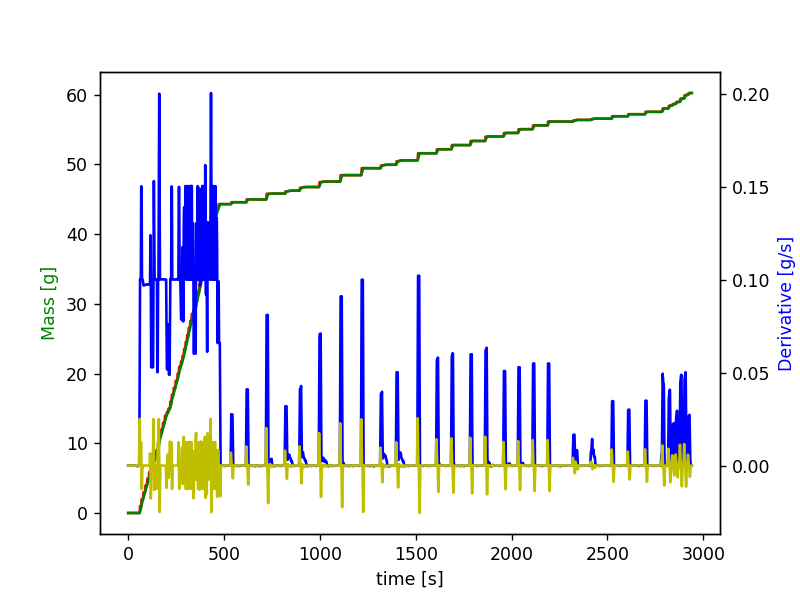

Addition of 0.275g Texapon SB 3 KC detected from 532s to 552s - expected volume = 0.508mL and actual volume = 0.249mL (resulting error is 51.042%)
Addition of 0.408g Texapon SB 3 KC detected from 612s to 632s - expected volume = 0.508mL and actual volume = 0.369mL (resulting error is 27.337%)
Addition of 0.844g Plantapon ACG 50 detected from 716s to 756s - expected volume = 0.813mL and actual volume = 0.75mL (resulting error is 7.749%)
Addition of 0.428g Plantapon LC 7 detected from 814s to 860s - expected volume = 0.504mL and actual volume = 0.406mL (resulting error is 19.321%)
Addition of 0.525g Plantapon LC 7 detected from 890s to 932s - expected volume = 0.504mL and actual volume = 0.499mL (resulting error is 0.868%)
Addition of 0.793g Plantacare 2000 detected from 992s to 1040s - expected volume = 0.864mL and actual volume = 0.733mL (resulting error is 15.198%)
Addition of 0.923g Dehyton MC detected from 1102s to 1130s - expected volume = 0.909mL and actual volume = 0.859mL (resul

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0018750000000000004 g/s and for 2nd derivative = 0.00046875 g/s^2


<IPython.core.display.Javascript object>


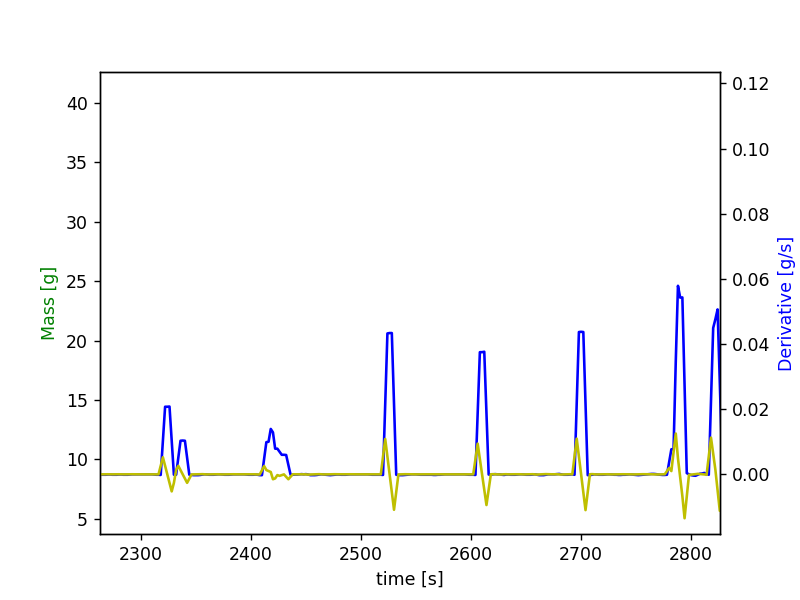

Addition of 0.246g Dehyquart CC6 detected from 2316s to 2348s - expected volume = 0.191mL and actual volume = 0.229mL (resulting error is 20.404%)
Addition of 0.188g Dehyquart CC6 detected from 2408s to 2440s - expected volume = 0.123mL and actual volume = 0.18mL (resulting error is 45.736%)
Addition of 0.344g Dehyquart CC6 detected from 2518s to 2536s - expected volume = 0.188mL and actual volume = 0.329mL (resulting error is 75.574%)
Addition of 0.299g Dehyquart CC6 detected from 2602s to 2620s - expected volume = 0.199mL and actual volume = 0.28mL (resulting error is 41.038%)
Addition of 0.347g Dehyquart CC6 detected from 2692s to 2710s - expected volume = 0.161mL and actual volume = 0.328mL (resulting error is 103.143%)
Addition of 0.495g Dehyquart CC6 detected from 2776s to 2800s - expected volume = 0.282mL and actual volume = 0.471mL (resulting error is 67.145%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


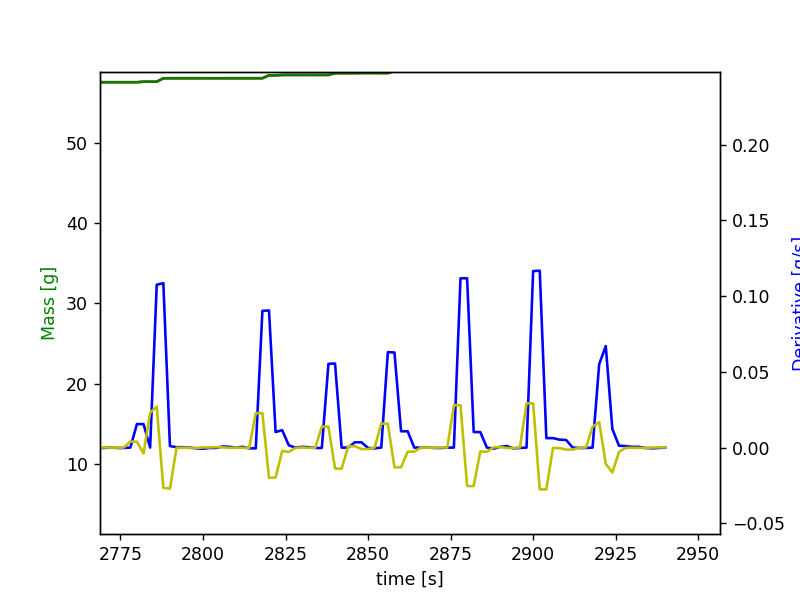

Addition of 0.408g Arlypon TT detected from 2814s to 2830s - expected volume = 0.454mL and actual volume = 0.419mL (resulting error is 7.692%)
Addition of 0.228g Arlypon TT detected from 2834s to 2846s - expected volume = 0.166mL and actual volume = 0.24mL (resulting error is 44.304%)
Addition of 0.293g Arlypon TT detected from 2852s to 2868s - expected volume = 0.271mL and actual volume = 0.308mL (resulting error is 13.566%)
Addition of 0.487g Arlypon TT detected from 2874s to 2890s - expected volume = 0.489mL and actual volume = 0.502mL (resulting error is 2.526%)
Addition of 0.509g Arlypon TT detected from 2896s to 2916s - expected volume = 0.476mL and actual volume = 0.529mL (resulting error is 11.245%)
Addition of 0.273g Arlypon TT detected from 2916s to 2930s - expected volume = 0.218mL and actual volume = 0.286mL (resulting error is 31.25%)


In [7]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [8]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_090523_S403-S408.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_26108\497018529.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
402,403.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.471244,10.373680,0.0,2.459256,0.0,0.0,0.0,4.084993
403,404.0,0.000000,8.355674,0.000000,0.0,7.848849,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.860996,0.0,0.0,0.0,2.256953
404,405.0,6.915806,0.000000,0.000000,0.0,0.000000,9.35239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.484993,0.0,0.0,0.0,2.967245
405,406.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,9.905631,0.000000,0.000000,0.000000,0.000000,10.864017,0.0,2.960304,0.0,0.0,0.0,4.821632
406,407.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,9.910258,11.478864,0.000000,0.000000,0.0,3.369788,0.0,0.0,0.0,4.942518
407,408.0,0.000000,0.000000,9.367219,0.0,0.000000,0.00000,0.000000,11.167926,0.000000,0.000000,0.000000,0.000000,0.0,4.862992,0.0,0.0,0.0,2.683369
